#**Movie Recommender System**

**Content Creator:** Mohitrajhu Lingan Kumaraian

**Reference:**
 * https://heartbeat.fritz.ai/recommender-systems-with-python-part-ii-collaborative-filtering-k-nearest-neighbors-algorithm-c8dcd5fd89b2


In this worksheet, we will see how to build a simple KNN based Recommender System that recommends movies based on the movies that users have watched before.

##**Short Background**

Many internet services such as Youtube, Netflix, Spotify are Recommender Systems. These systems are researched heavily and provide high value to the company. One instance is that Netflix offered $1,000,000 prize for a team that improved the accuracy of their recommendation system by 10%, since this is a key part of their multi-billion dollar business.  Recommender Systems can be divided into three categories: Content-Filtering systems, Collaborative Filtering systems and Hybrid systems--a combination of the other two systems .

**Content Filtering**  uses features of an item to recommend  similar items to users. It is used when a new user joins the platform as we don't know anything about the user's taste and behavioral pattern.

**Collaborative Filtering** uses a user's past behaviour--its similarity with other others--to recommend similar products to the user. It works on the idea that people who have had similar behaviors in the past will behave similarly in the future, i.e if two users have liked similar items in the past then they would also agree we can recommend items from one of the user's list of purchased/viewed items to another user who hasn't.

In this worksheet, we will recommend similar movies to the movies that the users have liked in the past based on the rating that the movie has garnered from different users.

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':"1h5fvp9dQcqPqh-VC_mWrZD5m26YIj03l"})   # replace the id with id of file you want to access
downloaded.GetContentFile('movies.csv')   

## The Dataset
We will use the Movielens dataset, which contains a set of movies and the ratings given to these movies by different users. Specifically, we use:

  * movies.csv, which contains movies with their corresponding ids
  * ratings.csv, which contains user ratings of the movies.

In [5]:
import pandas as pd
movies = pd.read_csv('movies.csv',usecols=['movie_id','movie'],encoding='unicode_escape')
movies = movies.reset_index()
print('Number of Movies:'+str(len(movies)))
movies.head(10)

Number of Movies:3883


,index,movie_id,movie
0,0,1,Toy Story (1995)
1,1,2,Jumanji (1995)
2,2,3,Grumpier Old Men (1995)
3,3,4,Waiting to Exhale (1995)
4,4,5,Father of the Bride Part II (1995)
5,5,6,Heat (1995)
6,6,7,Sabrina (1995)
7,7,8,Tom and Huck (1995)
8,8,9,Sudden Death (1995)
9,9,10,GoldenEye (1995)


In [6]:
downloaded = drive.CreateFile({'id':"1HGvJF2WIkhfqbgTLQYIMqR0e9_eimuqz"})
downloaded.GetContentFile("ratings.csv")

In [7]:
ratings_df = pd.read_csv('ratings.csv',index_col=False,usecols=['user_id','movie_id','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})
print('number of users:'+str(ratings_df['user_id'].nunique()))
print('number of user rating:'+str(len(ratings_df)))

number of users:6040
number of user rating:1000209


We will use the user rating similarity to cluster movies, and thus to recommend movies. 

One could also cluster people instead of movies. Thought question: how would that work? When might it be better?


**Feature matrix formation**

In [ ]:
from scipy.sparse import csr_matrix
movie_features = ratings_df.pivot(index='movie_id',columns='user_id',values='rating').fillna(0)
movie_features

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,4.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8412cac50>]],
      dtype=object)

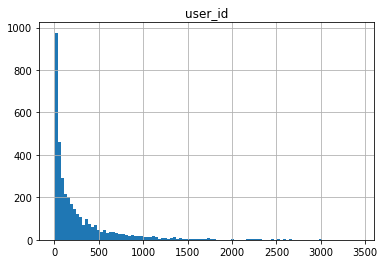

In [ ]:
rating_num = ratings_df.groupby(by='movie_id').count().reset_index()
rating_num.hist(column='user_id',bins=100)

As you see, the data  is very sparse.  To make the problem simpler, we remove users who have rated fewer than 50 movies and movies that have been rated by fewer than 50 users.  (Amazon, of course, doesn't have this luxury.)

In [ ]:
##Threshold to distinguish active user
user_thresh = 50
user_cnt = ratings_df.groupby(by='user_id').count().reset_index()
active_users = list(set(user_cnt.query('movie_id>=@user_thresh').index))
print("Number of active users: "+str(len(active_users)))
ratings_df_activeusers = ratings_df[ratings_df.user_id.isin(active_users)]
print("Length of rating dataframe after dropping inactive users: "+str(len(ratings_df_activeusers)))
## Threshold of number of user ratings to eliminate a movie
movie_pop_thresh = 50
movie_cnt = ratings_df_activeusers.groupby(by='movie_id').count().reset_index()
popular_movies = list(set(movie_cnt.query('user_id >= @movie_pop_thresh').index))
curated_ratings_df = ratings_df_activeusers[ratings_df_activeusers.movie_id.isin(popular_movies)]
print("Number of popular Movies above the set threshold: "+str(len(popular_movies)))
print('Length of final curated ratings dataframe: '+str(len(curated_ratings_df)))

Number of active users: 4297
Length of rating dataframe after dropping inactive users: 718941
Number of popular Movies above the set threshold: 2289
Length of final curated ratings dataframe: 427434


In [ ]:
curated_ratings_df

,user_id,movie_id,rating
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0
6,1,1287,5.0
7,1,2804,5.0
...,...,...,...
999863,6039,1081,4.0
999864,6039,1083,3.0
999865,6039,1086,4.0
999866,6039,1088,4.0


In [ ]:
movie_features = curated_ratings_df.pivot(index='movie_id',columns='user_id',values='rating').fillna(0)
movie_features 

user_id,1,2,4,5,7,8,9,10,12,14,16,17,18,21,22,23,24,25,26,27,28,30,32,33,34,35,36,37,38,39,41,43,44,47,48,51,52,55,56,57,...,5988,5989,5990,5991,5993,5994,5995,5996,5997,5999,6000,6001,6002,6003,6004,6005,6006,6008,6009,6010,6012,6013,6014,6015,6017,6018,6020,6022,6023,6024,6025,6029,6030,6031,6032,6034,6035,6036,6038,6039
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,5.0,5.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,4.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,4.0,5.0,0.0,0.0,5.0,0.0,...,0.0,5.0,0.0,4.0,0.0,0.0,5.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

movie_features_mat = csr_matrix(movie_features.values)

##Building Model

We will now build a simple KNN based Recommender System. The KNN model doesn't make any assumptions about the underlying data distribution. It simply calculates the similarity between the target movie and other movies in the database and ranks them in from most to least similar. Different similarity (or distance measures can be used. What options are there. Do you think Euclidian distance is good to use here? Why or why not?

We use Cosine similarity to measure the similarity (the normalized dot prodict) between any two movies, where each movie is represented as a vector of the people who have watched it:


<img src="https://drive.google.com/uc?id=1YcK3uWVMZjEvCFNg2U8FEOQ-ttmPKsn_">



In [ ]:
!pip install fuzzywuzzy


##Fitting the model

In [ ]:
from sklearn.neighbors import NearestNeighbors

recommender_knn = NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=18)

##Fitting the model
recommender_knn.fit(movie_features_mat)







NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=18, p=2,
                 radius=1.0)

In [ ]:
from fuzzywuzzy import process

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
movie_features_set = movie_features.reset_index()
movie_idx = list(set(movie_features_set['movie_id']))
## Hash map of movie names with their movie_id
hash_map = {list(movies.loc[movies['movie_id']==movie_id]['movie'])[0]:idx for idx,movie_id in enumerate(movie_idx)}


Index(['index', 'movie_id', 'movie'], dtype='object')


{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Waiting to Exhale (1995)': 3,
 'Father of the Bride Part II (1995)': 4,
 'Heat (1995)': 5,
 'Sabrina (1995)': 6,
 'Tom and Huck (1995)': 7,
 'Sudden Death (1995)': 8,
 'GoldenEye (1995)': 9,
 'American President, The (1995)': 10,
 'Dracula: Dead and Loving It (1995)': 11,
 'Balto (1995)': 12,
 'Nixon (1995)': 13,
 'Cutthroat Island (1995)': 14,
 'Casino (1995)': 15,
 'Sense and Sensibility (1995)': 16,
 'Four Rooms (1995)': 17,
 'Ace Ventura: When Nature Calls (1995)': 18,
 'Money Train (1995)': 19,
 'Get Shorty (1995)': 20,
 'Copycat (1995)': 21,
 'Assassins (1995)': 22,
 'Powder (1995)': 23,
 'Leaving Las Vegas (1995)': 24,
 'Now and Then (1995)': 25,
 'Persuasion (1995)': 26,
 'City of Lost Children, The (1995)': 27,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 28,
 'Dangerous Minds (1995)': 29,
 'Wings of Courage (1995)': 30,
 'Carrington (1995)': 31,
 'It Takes Two (1995)': 32,
 'Cry, the Be

##The prediction
Enter your favorite movie (make sure it is in the list) and see what movies the system recommends. How well does it work? Any patterns to when it  is better or worse?
Note: This is a very basic recommendation system with a small data set so its performance is as good as the one Netflix uses.

In [ ]:
import time
##Enter Favorite movie here
fav_movie = 'Toy Story'
## number of movies that you want the recommender system to recommend
num_recommendations = 10
start = time.time()
print('Recommendation in process')
idx = hash_map[process.extractOne(fav_movie,list(hash_map.keys()))[0]]
similarity,idxs = recommender_knn.kneighbors(movie_features_mat[idx],n_neighbors=num_recommendations+1)
idx_recommends = sorted(list(zip(similarity.squeeze().tolist(),idxs.squeeze().tolist())),key=lambda x:x[0])[:0:-1]
rev_map = {idx:movie for movie,idx in hash_map.items()}
print('Recommendations for movies similar to {}'.format(fav_movie))
for i,(similarity,idx) in enumerate(idx_recommends):
  print('{0}:{1} with a similarity of {2}'.format(i+1,rev_map[idx],similarity))
print('time taken:{}'.format(time.time()-start))

Recommendation in process
Recommendations for movies similar to Toy Story
1:Fugitive, The (1993) with a similarity of 0.4689079523086548
2:Shakespeare in Love (1998) with a similarity of 0.4687601327896118
3:E.T. the Extra-Terrestrial (1982) with a similarity of 0.4681999683380127
4:Forrest Gump (1994) with a similarity of 0.4580477476119995
5:Matrix, The (1999) with a similarity of 0.44430750608444214
6:Back to the Future (1985) with a similarity of 0.4346410036087036
7:Bug's Life, A (1998) with a similarity of 0.40999841690063477
8:Aladdin (1992) with a similarity of 0.3953664302825928
9:Groundhog Day (1993) with a similarity of 0.38452035188674927
10:Toy Story 2 (1999) with a similarity of 0.36692821979522705
time taken:0.9416115283966064


We can also build Recommender systems that use Deep Learning where we embed the movie features in a latent space and compute similarity in that space to cluster similar movies to recommend to the user. This is one of the ways to build a recommender systems. What other models can you think about that can be used to build these systems? 

**If you find this interesting, this is an interesting idea for final project :)**